# Gevers et al Case Study 

In this notebook, we will take concepts we learned about in `the-importance-of-being-scale-invariant.ipynb` in an Inflammatory Bowel Disease (IBD) microbiome dataset.  In particular, we will use a subset of the [Gevers et al](https://pubmed.ncbi.nlm.nih.gov/24629344/) dataset that was retrieved from [Qiita](https://qiita.ucsd.edu/study/description/1939)


The goal of this notebook is to (1) determine if there is a difference between patients who have IBD and those that don't and (2) determine which microbes could explain these differences. The broader framework we will be exploring is called Differential Abundance analysis (or Differential Expression analysis if you analyzing RNAseq data, the concept is identical). To answer these questions, we will use a probabilistic programming framework called Stan to allow us to fit a Generalized Linear Model on the Gevers et al dataset.  Specifically, we will fit a Negative Binomial regression using the ALR transform that we covered earlier.

One may ask, why would we want to go Bayesian?

There are a number of reasons why we would want to employ a Bayesian approach to differential abundance analysis, namely
1. Our dataset is highly sparse.  This means that if we want to employ the log-ratio methodology discussed earlier, the Differential Abundance problem becomes a missing data problem, since logarithms cannot be evaluated on zeros.  This approach quickly becomes ill-defined in a Frequentist regime (i.e. how would one deal with microbes that are only found in 1 group?).
2. We will want to employ hierarchical models that can explicitly model technical variation induced by counting sequences, while keeping the model parameters interpretable in the compositional data analysis framework we outlined earlier.

The Negative Binomial regression framework is an example of a simple hierarchical model that is already commonly used by tools such as edgeR and DESeq2.  Here, we will show you how to design your own model in Stan and interpret the model quantities.

But first, we'll need to load the appropriate Python libraries and datasets.  In particular, we will want to load a table of the microbial counts collected across samples, in addition to the accomodating sample metadata information.

In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

md = pd.read_table('../data/gevers/rectum_metadata.txt', index_col=0)
table = pd.read_table('../data/gevers/rectum_table.txt', index_col=0)

The microbial count table (commonly referred to as the Biom Table), is a profile of microbial "species" counts within each sample. The reason why "species" is highlighted is because the term microbial species is still not standardized -- unlike Eurkaryotic organisms, microbes can exchange DNA amongst completely unrelated microbes, defying the standard definitions of species.  Because of this edge case, there are a number of methodologies that have attempted to carve out their alternative to microbial species, commonly called OTUs (Operational Taxonomic Units).  

In this particular case, we have collapsed the OTUs to Genus level, where OTU abundances within each genus are averaged together.  This allows us to simplify the dataset reducing the dimensionality from 8000+ OTUs to 113 genera.  As a result, we have reduced the taxonomic resolution, but the resulting data is easier to handle and easier to interpret.  Below is an example of what this dataset would look like, where the column names correspond to the microbial taxonomic names and the rownames correspond to biological samples collected from rectum swabs.  The values in below represent the number of times a genus was observed in the corresponding biological sample using 16S sequencing.  With 16S sequencing, 1 single sequencing read is enough to uniquely identify 1 microbe, so we can just count the number of sequencing reads to count the number of microbes.  There are certainly edge cases to this procedure, but that is a discussion for another time.

In [2]:
table.head()

,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__,k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Adlercreutzia,k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Atopobium,k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella,k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Eggerthella,k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Slackia,...,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Actinobacillus,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Aggregatibacter,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Moraxella,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas,k__Bacteria;p__Spirochaetes;c__Spirochaetes;o__Spirochaetales;f__Spirochaetaceae;g__Treponema,k__Bacteria;p__Tenericutes;c__Mollicutes;o__RF39;f__;g__,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia
sample_id,,,,,,,,,,,,,,,,,,,,,
1939.MGH100695.a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1939.MGH100695.b,39.0,0.0,0.0,38.0,9.0,0.0,0.0,53.0,0.0,9.0,...,0.0,4.0,130.0,58.0,0.0,0.0,0.0,0.0,185.0,3.0
1939.MGH101446,10.0,0.0,0.0,3.0,3.0,1.0,8.0,179.0,0.0,0.0,...,0.0,249.0,44.0,0.0,0.0,0.0,0.0,0.0,5.0,2280.0
1939.MGH101666,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,221.0,0.0,0.0,0.0,1.0,0.0,0.0,28.0
1939.MGH102261,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,8.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0


The sample metadata information provides information surrounding the sample collection in addition to other factors such as the patient disease subtype.  For the sake of this tutorial, we will focus on the disease diagnosis, specifically people who are diagnosed with Crohn's disease (CD), people who are diagnosed with Ulcerative Colitis (UC), and people who don't have IBD are serve in the control group.  The patients in the control group are indicated by a (no) label.

In this particular study there was exactly 1 rectal swab collected from each patient.  The number of people in each group are given below.

In [3]:
md['diagnosis'].value_counts()

CD    161
no    107
UC     31
Name: diagnosis, dtype: int64

Now we have been introduced to our data, we use a program in Stan to perform a Negative Binomial regression.
The goal here is two fold: (1) determine if there is a difference between microbial profiles between the control group and the IBD patients and (2) determine which microbes can explain the differences between these groups.

Briefly our proposed model given as follows

$$
y_{ij} \sim \mathrm{NB}(\delta_i  \lambda_{ij},  \alpha) \in \mathbb{N} \\
\lambda_{i} = alr^{-1}(x_i \cdot \beta) \in \mathbb{R}^{d}_+\\
\frac{1}{\alpha} \sim \mathrm{Gamma}(1, 1) \in \mathbb{R}_+ \\
\beta \sim \mathcal{N}(0, 10) \in \mathbb{R}^{p \times d - 1}
$$

where $y_{ij}$ corresponds to the microbial counts for taxa $j$ and sample $i$, and $x_{i}\in\mathbb{R}^{p}$ corresponds to the covariates within each sample. $\delta_i$ corresponds to the sequencing depth (i.e. number of reads sequenced for each sample), $p$ are the number of covariates, $d$ is the number of microbes, $n$ is the number of samples.  $\lambda_{i} \in \mathbb{R}^{d}$ corresponds to the rate parameter of the Negative Binomial distribution, which here translates to the predicted proportion of microbe $j$ in sample $i$.  $\alpha\in\mathbb{R}_+$ is an overdispersion parameter that can help better model the variance of the data.

The quantity we are most interested in is $\beta$, since this will give us an estimate of the __log-fold change__ in this case study.  Here we have placed a weakly informed normal prior over $\beta$ in the hopes that it will be able to handle the small dataset since given here.  One thing that is important to note here is that we are using the inverse ALR transform instead of the ALR transform; this is intentional since our dataset is very sparse (mostly zero counts), we need to be able to handle these zeros.  Rather than trying to impute the zeros, we will utilize use Stan to explicitly model the generative process.  Doing so allows us to model the microbial proportions with the inverse ALR transform, which is then used to generate counts with the Negative Binomial distribution.  The take away here is that $\beta$ is represented by the log-ratios represented in the ALR transform introduced earlier; we will later show how log-fold change can be extracted from the model estimate shortly.

The Stan program behind this model is found below. We will then use Automatic Differentiation Variational Inference (ADVI) to fit this model. If you are curious about the details behind the GLM, feel free to check out the following blog post on this

https://mortonjt.github.io/probable-bug-bytes/probable-bug-bytes/differential-abundance/

In [4]:
print(open('nb_diff.stan').read())

data {
  int<lower=0> n;     // number of samples
  int<lower=0> d;     // number of samples
  int<lower=0> p;     // number of covariates
  real depth[n];      // sequencing depths of microbes (in log counts)
  matrix[n, p] x;     // covariate matrix
  int y[n, d];        // observed microbe abundances
}

parameters {
  // parameters required for linear regression on the species means
  matrix[p, d-1] beta;  // covariates
  real<lower=0> disp; // over-dispersion to help control for variance
}

transformed parameters {
  matrix[n, d] lam;
  // compute log(alr^{-1}(x * \beta))
  lam = append_col(to_vector(rep_array(0, n)), x * beta);
}

model {
  // setting priors ...
  disp ~ inv_gamma(1., 1.);
  to_vector(beta) ~ normal(0., 10.); // uninformed prior
  // generating counts
  for (i in 1:n){
    for (j in 1:d){
      target += neg_binomial_2_log_lpmf(y[i, j] | depth[n] + lam[i, j], disp);
    }
  }
}



In our particular use case, we only have 3 covariates, namely the 3 diagnostic groups UC, CD and control (no).
As a result, the main thing we want to do is to be able to estimate the log-fold change between the groups.
We can use statistical libraries such as patsy to design a constrast matrix, where we will represent these differences as one hot encodings.  This covariate matrix will then be represented by 3 variables, namely `Intercept`, `CD vs Control` and `UC vs Control`. This can be done with the code below.

A more detailed discussion behind design matrices can be found at 

https://mortonjt.github.io/probable-bug-bytes/probable-bug-bytes/regression-intercept/

http://mortonjt.blogspot.com/2018/05/encoding-design-matrices-in-patsy.html

In [5]:
from patsy import dmatrix
disease_type = dmatrix("C(diagnosis, Treatment('no'))", md, return_type='dataframe')
disease_type.head()

,Intercept,"C(diagnosis, Treatment('no'))[T.CD]","C(diagnosis, Treatment('no'))[T.UC]"
sample_id,,,
1939.MGH100695.a,1.0,1.0,0.0
1939.MGH100695.b,1.0,1.0,0.0
1939.MGH101446,1.0,1.0,0.0
1939.MGH101666,1.0,0.0,0.0
1939.MGH102261,1.0,0.0,1.0


Now that we have introduced the model and the data, we will coerce the input data into a format that is recognizable by Stan.  CMDStan takes in as input a json file that is written to disk, which can be achieved by the following code.

In [6]:
import json
nb_data = {
    'n' : len(table),                                     # number of samples
    'd' : table.shape[1],                                 # number of microbes
    'p' : disease_type.shape[1],                          # number of covariates
    'depth' : np.log(table.sum(axis=1)).values.tolist(),  # log of sequencing depth
    'x' : disease_type.values.tolist(),                   # covariates represented as one-hot encodings
    'y' : table.values.astype(np.int64).tolist()          # microbial counts
}
with open('data.json', 'w') as f:
    json.dump(nb_data, f)

Now that we have our data formatted, now we can run ADVI and try to obtain model estimates.

In [7]:
%set_env TBB_CXX_TYPE gcc
import os
nb_model = CmdStanModel(stan_file=os.path.join(os.getcwd(), 'nb_diff.stan'))
fit = nb_model.variational(data='data.json')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/juermieboop/Documents/interviews/bch/short-introduction-to-ALR/ipynb/nb_diff
INFO:cmdstanpy:start chain 1


env: TBB_CXX_TYPE=gcc


INFO:cmdstanpy:finish chain 1


Once we have obtained model estimates, we can also sample from the posterior distribution.  
This allows us to quantify the uncertainty surrounding our model parameters.

In [11]:
from util import extract_log_fold_change
beta_samples = extract_log_fold_change(fit, n=table.shape[1], p=disease_type.shape[1])
# Compute means and std dev surrounding our log-fold change estimates
beta_mean = beta_samples.mean(axis=0)
beta_std = beta_samples.std(axis=0)

To evaluate which column of beta corresponds to the log-fold change between CD compared to C.ontrol, 
we first need to remind ourselves how the design matrix was formatted.  Looking at the columns of the design matrix,
we can see that the second column corresponds to the CD vs Control covariate.  So we will pull out that
column of the beta variable.

In [12]:
disease_type.columns.tolist()

['Intercept',
 "C(diagnosis, Treatment('no'))[T.CD]",
 "C(diagnosis, Treatment('no'))[T.UC]"]

By default, we chose the first feature to be the reference feature.  If we want to match 
the log-fold change values with the microbial names, we can designate the first feature to 
have a zero log-fold change as mentioned in the previous notebook.

We will now tidy up the CD vs Control log-fold change values and visualize the means and standard deviations for the log-fold change estimates.

Text(0, 0.5, '$log(Control/CD) + K$')

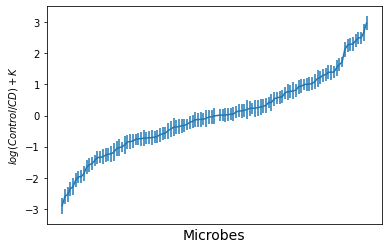

In [16]:
import matplotlib.pyplot as plt

ctrl_cd = 1  # grab the log-fold change corresponding to CD vs Control
differentials = pd.DataFrame({
    'mean': [0] + beta_mean[:, ctrl_cd].tolist(), 'std': [0] + beta_std[:, ctrl_cd].tolist()},
    index=table.columns)
differentials = differentials.sort_values('mean')

fig, ax = plt.subplots()
ax.errorbar(np.arange(len(differentials)), differentials['mean'], yerr=differentials['std'])
ax.set_xticks([])
ax.set_xlabel('Microbes', fontsize=14)
ax.set_ylabel('$log(Control/CD) + K$')

On the y-axis of this plot, we denoted the log-fold change per microbe up to some unknown constant K.
This constant is due to the change of the total biomass that we cannot directly measure.  

It turns out that unless we are performing hypothesis tests on each microbial feature,
it doesn't really matter which reference we chose.  The reason is because we don't necessarily know 
which microbe is changing in abundance.  As a result, our choice of reference won't necessarily be
indicative of determining if a microbe has changed in abundance.

Now, _if_ you are able to determine which confidence which microbe is not changing, then you will
be able to make much stronger statements about microbial log-fold change.  But figuring this out is still an outstanding question.

BUT, even though we can't figure out what K is, we can always sort the microbes according to their log-fold change, since ranking is a scale-invariant operation.  Recalling out notation in the previous section, where $A$ and $B$ refer to the ground truth abundances between two conditions and $p_A$ and $p_B$ are the corresponding proportions, the following statement holds.

$$rank\big(\frac{A}{B}\big) = rank\big(\frac{p_A}{p_B}\big)$$

This holds because the bias $K$ applies to every microbe equally.  As a result, we can still sort the microbes according to their log-fold change and identify the microbes that increased the most and microbes that decreased the most.

So, let's who the top most increased microbes and top more decreased microbes are.

In [54]:
differentials.head(20)

,mean,std
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Alicycliphilus,-2.898736,0.261368
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Epulopiscium,-2.597962,0.234430
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,-2.536195,0.244721
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Megamonas,-2.351506,0.217571
k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Adlercreutzia,-2.284217,0.284247
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__Paraprevotella,-2.071902,0.214061
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Megasphaera,-1.966108,0.193813
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__,-1.964276,0.200099
k__Bacteria;p__Tenericutes;c__Mollicutes;o__RF39;f__;g__,-1.869300,0.233279
k__Bacteria;p__Firmicutes;c__Bacilli;o__Turicibacterales;f__Turicibacteraceae;g__Turicibacter,-1.658010,0.232382


In [55]:
differentials.tail(20)

,mean,std
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia,1.092910,0.227672
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Moraxella,1.189515,0.259315
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__[Tissierellaceae];g__Anaerococcus,1.221614,0.212661
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Aggregatibacter,1.297860,0.208737
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Eikenella,1.309592,0.211117
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Erwinia,1.389300,0.230333
k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__[Weeksellaceae];g__,1.390022,0.245553
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Lautropia,1.395832,0.190013
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Serratia,1.533259,0.254360
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Actinobacillus,1.639519,0.219621


Another cool thing about this approach is the log-fold change could also be interpreted as a type of feature-importance; the microbes the increased the most and decreased the most are the microbes that best describe the differences between the CD and Control samples.  Furthermore, we can design *classifiers* with this sort of information; by selecting the top microbes and bottom microbes, we can compute their average log ratio per sample which can serve as a 1D classifier given by

$$
\log\bigg(\frac{g(x_{top} + 1)}{g(x_{bottom} + 1)}\bigg) 
$$

Where $x_{top}$ corresponds to the abundances of the most increased microbes, $x_{bottom}$ corresponds to the abundances of the most decreased microbes and $g(x)$ is the geometric mean.  Since there are many zero counts, we do need some imputation, so we add a pseudocount to alleviate this issue.  

The code to compute this log-ratio across the top 20 microbes and bottom microbes is given below.

In [56]:
numerator = np.log(table.loc[:, differentials.head(20).index] + 1)
denominator = np.log(table.loc[:, differentials.tail(20).index] + 1)
balance = numerator.mean(axis=1) - denominator.mean(axis=1)
md['TopTaxaLogRatio'] = balance

To see how reasonable this log-ratio is, we investigate the distribution of the 3 patient groups for this log-ratio below

<AxesSubplot:xlabel='diagnosis', ylabel='TopTaxaLogRatio'>

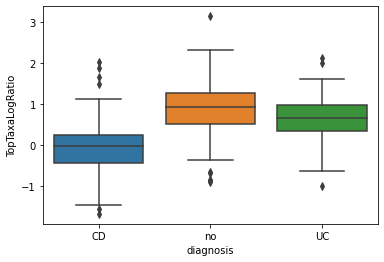

In [57]:
import seaborn as sns
sns.boxplot(x='diagnosis', y='TopTaxaLogRatio', data=md)

We can see, there is a huge separation between the Control group (no) and the CD group.  We can further validate this by calculating the AUC.

In [58]:
from sklearn import metrics
truth = md['diagnosis'].values == 'no'
pred = balance.values
fpr, tpr, thresholds = metrics.roc_curve(truth, pred)
metrics.auc(fpr, tpr)

0.8091900311526479

One interesting thing about this is the training AUC is slightly better than the AUC of 0.78 that was obtained using Random Forests in the original dataset.  And this approach only used 1 dimension!

Before we get too excited, we do need to point out the potential caveats.  We aren't performing cross-validation, so there is always the possibility that we are overfitting. If we wanted to be rigorious about this approach, we would want to do careful cross-validation, where we train our differential abundance on a subset of the dataset, and evaluate our classification accuracy on a hold out dataset.

Indeed we can and should do this!  This tutorial is designed to give a sense of the additional possibilities surrounding differential abundance analysis that could be exercised.

# Conclusion

There is a huge world of possibilities surrounding differential abundance analysis that can be realized with insights from Compositional Data Analysis.  It is important to note that this is just the tip of the iceberg. There are many more things that can be discussed in the context of correlations, dimensionality reduction, classification and much more!